# Repulsive mixtures with repulsive vs non-repulsive priors

## Galaxy Data

### Histogram of galaxy data overlaid with a nonparametric density estimate using Gaussian kernel density estimation

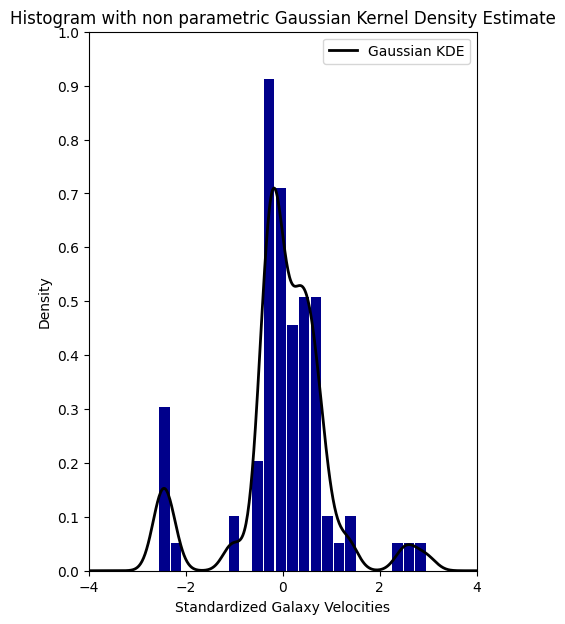

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Given galaxy velocity data
galaxy_velocities = np.array([9172, 9350, 9483, 9558, 9775, 10227, 10406, 16084, 16170, 18419,
                              18552, 18600, 18927, 19052, 19070, 19330, 19343, 19349, 19440, 19473,
                              19529, 19541, 19547, 19663, 19846, 19856, 19863, 19914, 19918, 19973,
                              19989, 20166, 20175, 20179, 20196, 20215, 20221, 20415, 20629, 20795,
                              20821, 20846, 20875, 20986, 21137, 21492, 21701, 21814, 21921, 21960,
                              22185, 22209, 22242, 22249, 22314, 22374, 22495, 22746, 22747, 22888,
                              22914, 23206, 23241, 23263, 23484, 23538, 23542, 23666, 23706, 23711,
                              24129, 24285, 24289, 24366, 24717, 24990, 25633, 26960, 26995, 32065,
                              32789, 34279])

# Standardize the galaxy velocities (Z-score normalization)
mean_velocity = np.mean(galaxy_velocities)
std_velocity = np.std(galaxy_velocities)
galaxy_velocities_standardized = (galaxy_velocities - mean_velocity) / std_velocity

# Plot histogram with Gauussian KDE
plt.figure(figsize=(5, 7))

# Histogram
counts, bins, patches = plt.hist(galaxy_velocities_standardized, bins=23, density=True, color='darkblue', rwidth = 0.9)

# Gaussian KDE
kde = gaussian_kde(galaxy_velocities_standardized, bw_method = 0.2)
x_vals = np.linspace(-4, 4, 500)  
kde_vals = kde(x_vals)

# Plot KDE 
plt.plot(x_vals, kde_vals, color='black', linewidth=2, label='Gaussian KDE')

plt.xlabel("Standardized Galaxy Velocities")
plt.ylabel("Density")
plt.title("Histogram with non parametric Gaussian Kernel Density Estimate")
plt.xlim(-4, 4)
plt.ylim(0,1)
plt.xticks([-4, -2, 0, 2, 4]) 
plt.yticks(np.arange(0, 1.1, 0.1))  

plt.legend()
plt.show()

This reveals that there are 3 non-overlapping clusters with the one close to the origin relatively larger compared to the others.

### Estimated Clusters under Galaxy Data for non-repulsive and repulsive priors

### Definition 1

A density $h(\gamma)$ is **repulsive** if for any $\delta > 0$ there is a corresponding $\epsilon > 0$ such that:

$$
h(\gamma) < \delta \quad \text{for all } \gamma \in \Gamma \setminus G_{\epsilon},
$$

where

$$
G_{\epsilon} = \{\gamma : d(\gamma_s, \gamma_j) > \epsilon; \, s = 1, \dots, k; \, j < s\}
$$

and $d$ is a distance.

We consider two special cases:

(i) $d(\gamma_s, \gamma_j)$ is the distance between the $s$th and $j$th kernel.
(ii)) $d(\gamma_s, \gamma_j)$ is the distance between sub-vectors of $\gamma_s$ and $\gamma_j$ corresponding to only locations.

Priors following **definition 1(i)** limit **over-fitting** in density estimation, while priors following **definition 1(ii)** favor well-separated clusters.





***A repulsive mixture model, following Definition 1(i), was applied to the galaxy data using a five-component mixture model. The Markov Chain Monte Carlo (MCMC) sampler was employed for prior specification, and the relabeling technique was implemented following Stephens' (2002) algorithm, ensuring that samples were post-processed to address the label switching problem.***

### Repulsive Mixture with Non-Repulsive Prior

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_91017/823426171.py:48: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(bayesian_gmm_histogram_weights), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
sample: 100%|██████████| 15000/15000 [00:33<00:00, 452.34it/s, 63 steps of size 4.01e-02. acc. prob=0.96] 


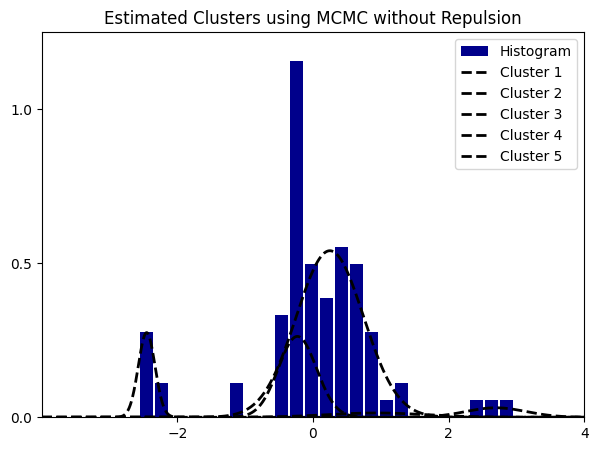

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

# Standardize the galaxy velocity data
scaler = StandardScaler()
galaxy_velocities_scaled = scaler.fit_transform(galaxy_velocities.reshape(-1, 1)).flatten()

# Compute original data mean
data_mean = np.mean(galaxy_velocities)

# Define the number of components (upper bound)
K = 5  

from sklearn.cluster import KMeans

# Use KMeans to Identify Natural Cluster Centers
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(galaxy_velocities_scaled.reshape(-1, 1))
initial_means = np.sort(kmeans.cluster_centers_.flatten())  # Ensure ordering

# Use Data-Driven Weights
counts, _ = np.histogram(galaxy_velocities_scaled, bins=K, density=True)
hist_weights = counts / np.sum(counts)  # Normalize to sum to 1

# Add Concentration to Weights
concentration_param = 5  # Adjust this to control cluster height variability
hist_weights = hist_weights * concentration_param
hist_weights += 0.1  # Small value to avoid zeros
hist_weights /= np.sum(hist_weights)  # Normalize again

def bayesian_gmm_histogram_weights(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.array(hist_weights)))  # Data-driven cluster heights
    means = numpyro.sample("means", dist.Normal(jnp.array(initial_means), 0.2).expand([K]))  # Cluster centers
    std_devs = numpyro.sample("std_devs", dist.HalfNormal(0.8).expand([K]))  # Cluster spread

    # Likelihood: Gaussian Mixture (No Repulsion Term)
    components = dist.Normal(means, std_devs)
    numpyro.sample("obs", dist.MixtureSameFamily(dist.Categorical(weights), components), obs=data)


# Set up MCMC with Slice Sampling
mcmc = MCMC(NUTS(bayesian_gmm_histogram_weights), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), data=jnp.array(galaxy_velocities_scaled))

# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Apply Relabeling Algorithm (Stephens, 2002)
# Compute posterior mean ordering to fix label switching
sorted_indices = np.argsort(np.mean(posterior_samples["means"], axis=0))
posterior_samples["means"] = posterior_samples["means"][:, sorted_indices]
posterior_samples["weights"] = posterior_samples["weights"][:, sorted_indices]
posterior_samples["std_devs"] = posterior_samples["std_devs"][:, sorted_indices]

# Generate density estimates for visualization
x_vals = np.linspace(-4, 4, 1000)
pdf_mixture = np.zeros_like(x_vals)

# Compute mixture density using posterior samples
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_mixture += weight_samples * norm.pdf(x_vals, mean_samples, std_samples)

# Plot histogram with KDE
plt.figure(figsize=(7, 5))
plt.hist(galaxy_velocities_scaled, bins=25, density=True, color='darkblue', rwidth=0.9, label="Histogram")
# Plot each individual Gaussian component separately
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_cluster = weight_samples * norm.pdf(x_vals, mean_samples, std_samples)
    plt.plot(x_vals, pdf_cluster, '--', color='black', linewidth=2, label=f"Cluster {i+1}")  # Dashed lines for each component

plt.xlim(-4, 4)
plt.ylim(0, 1.25)
plt.xticks([-2, 0, 2, 4])
plt.yticks([0, 0.5, 1])
plt.title("Estimated Clusters using MCMC without Repulsion")
plt.legend()

plt.show()


### Repulsive Mixture with Repulsive prior

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.cluster import KMeans


# Standardize the galaxy velocity data
scaler = StandardScaler()
galaxy_velocities_scaled = scaler.fit_transform(galaxy_velocities.reshape(-1, 1)).flatten()

# Compute original data mean
data_mean = np.mean(galaxy_velocities)

# Define the number of components (upper bound)
K = 5  

# Use KMeans to Identify Natural Cluster Centers
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(galaxy_velocities_scaled.reshape(-1, 1))
initial_means = np.sort(kmeans.cluster_centers_.flatten())  # Ensure ordering

# Use Data-Driven Weights
counts, _ = np.histogram(galaxy_velocities_scaled, bins=K, density=True)
hist_weights = counts / np.sum(counts)  # Normalize to sum to 1

# Add Concentration to Weights
concentration_param = 5  # Adjust this to control cluster height variability
hist_weights = hist_weights * concentration_param
hist_weights += 0.1  # Small value to avoid zeros
hist_weights /= np.sum(hist_weights)  # Normalize again

def bayesian_gmm_with_repulsion(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.array(hist_weights)))  # Data-driven cluster heights
    means = numpyro.sample("means", dist.Normal(jnp.array(initial_means), 0.2).expand([K]))  # Cluster centers
    std_devs = numpyro.sample("std_devs", dist.HalfNormal(0.8).expand([K]))  # Cluster spread

    # Repulsion Term - Definition 1(i)
    epsilon = 0.5  # Minimum separation threshold
    repulsion_penalty = jnp.sum(jnp.exp(-jnp.square(jnp.diff(jnp.sort(means))) / (2 * epsilon**2)))
    numpyro.factor("repulsion", -repulsion_penalty * 20)  # Apply repulsion penalty

    # Likelihood: Gaussian Mixture
    components = dist.Normal(means, std_devs)
    numpyro.sample("obs", dist.MixtureSameFamily(dist.Categorical(weights), components), obs=data)

# Set up MCMC with Slice Sampling
mcmc = MCMC(NUTS(bayesian_gmm_with_repulsion), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), data=jnp.array(galaxy_velocities_scaled))

# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Apply Relabeling Algorithm (Stephens, 2002)
# Compute posterior mean ordering to fix label switching
sorted_indices = np.argsort(np.mean(posterior_samples["means"], axis=0))
posterior_samples["means"] = posterior_samples["means"][:, sorted_indices]
posterior_samples["weights"] = posterior_samples["weights"][:, sorted_indices]
posterior_samples["std_devs"] = posterior_samples["std_devs"][:, sorted_indices]

# Generate density estimates for visualization
x_vals = np.linspace(-4, 4, 1000)
pdf_mixture = np.zeros_like(x_vals)

# Compute mixture density using posterior samples
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_mixture += weight_samples * norm.pdf(x_vals, mean_samples, std_samples)

# Plot histogram with KDE
plt.figure(figsize=(7, 5))
plt.hist(galaxy_velocities_scaled, bins=25, density=True, color='darkblue', rwidth=0.9, label="Histogram")

# Plot each individual Gaussian component separately with black dashed lines
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_cluster = weight_samples * norm.pdf(x_vals, mean_samples, std_samples)
    plt.plot(x_vals, pdf_cluster, '--', color='black', linewidth=2, label=f"Cluster {i+1}")  


plt.xlim(-4, 4)
plt.ylim(0, 1.25)
plt.xticks([-2, 0, 2, 4])
plt.yticks([0, 0.5, 1])
plt.title("Estimated Clusters using MCMC with Repulsion")
plt.legend()

plt.show()


/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_91017/1301021623.py:52: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(bayesian_gmm_with_repulsion), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
warmup:  23%|██▎       | 3445/15000 [00:04<00:16, 711.38it/s, 15 steps of size 1.22e-01. acc. prob=0.79] 

## Acidity Data

The second data set concerns an acidity index measured in a sample of 155 lakes in the Northeastern United States and has been previously  analysed as a mixture of gaussian distributions on the log scale by Crawford 

In [ ]:
acidity_data = np.array([
    2.928524, 3.910021, 3.732896, 3.688879, 3.822098, 3.735286, 4.143135,
    4.276666, 3.931826, 4.077537, 4.779123, 4.234107, 4.276666, 4.543295,
    6.467388, 4.127134, 3.977811, 4.264087, 4.007333, 3.921973, 5.384495,
    4.912655, 4.046554, 4.043051, 4.406719, 4.505350, 3.931826, 6.752270,
    6.928538, 5.994460, 4.248495, 4.060443, 4.727388, 6.047372, 4.082609,
    4.244200, 4.890349, 4.416428, 5.743003, 4.127134, 5.489764, 4.778283,
    5.249652, 4.855929, 4.128746, 4.442651, 4.025352, 4.290459, 4.593098,
    4.652054, 4.178992, 4.382027, 5.569489, 5.049856, 4.188138, 6.629363,
    4.647271, 4.784989, 4.348987, 5.361292, 4.574711, 4.442651, 6.120297,
    4.060443, 4.143135, 4.510860, 6.049733, 4.510860, 4.406719, 6.343880,
    4.430817, 5.929589, 5.973301, 4.481872, 4.301359, 6.452680, 4.204693,
    4.143135, 6.603944, 4.644391, 5.863631, 4.025352, 5.717028, 5.308268,
    6.267201, 4.060443, 5.017280, 4.510860, 5.834811, 4.330733, 4.007333,
    6.806829, 5.257495, 4.624973, 4.781641, 4.099332, 7.044382, 3.914021,
    4.330733, 4.016383, 5.572154, 4.043051, 4.843399, 4.110874, 4.454347,
    4.356709, 6.154858, 6.284321, 6.978214, 4.301359, 5.929855, 4.465908,
    6.035481, 6.726473, 7.105130, 6.014937, 4.882802, 7.032095, 4.518522,
    6.476665, 6.125558, 4.189655, 5.323498, 4.938065, 6.313548, 5.853925,
    6.278146, 7.020191, 5.023881, 4.262680, 6.725634, 6.489205, 5.743003,
    6.739337, 6.466145, 6.855409, 5.120983, 5.913773, 6.516932, 4.058717,
    6.213608, 6.554218, 6.155707, 4.314818, 6.662494, 6.749931, 6.100319,
    4.112512, 6.946014, 4.131961, 6.234411, 6.595781, 6.683861, 6.957973,
    4.497585
])



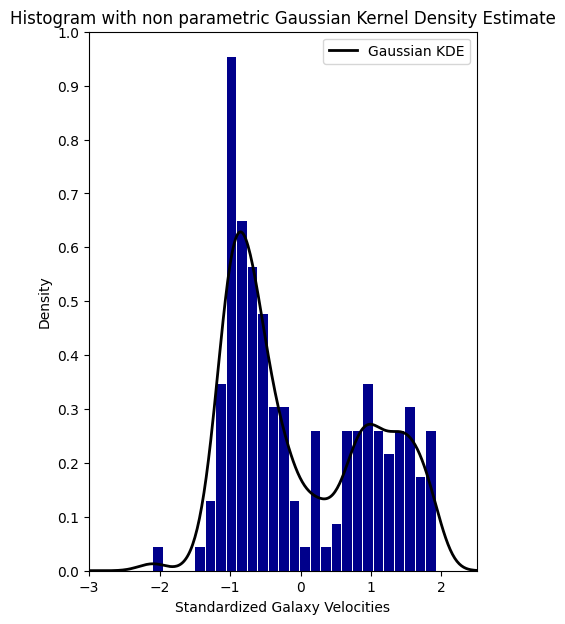

In [ ]:
# Standardize the acidity velocities (Z-score normalization)
mean_velocity = np.mean(acidity_data)
std_velocity = np.std(acidity_data)
acidity_data_standardized = (acidity_data - mean_velocity) / std_velocity

# Plot histogram with Gauussian KDE
plt.figure(figsize=(5, 7))

# Histogram
counts, bins, patches = plt.hist(acidity_data_standardized, bins=27, density=True, color='darkblue', rwidth = 0.9)

# Gaussian KDE
kde = gaussian_kde(acidity_data_standardized, bw_method = 0.2)
x_vals = np.linspace(-4, 4, 500)  
kde_vals = kde(x_vals)

# Plot KDE 
plt.plot(x_vals, kde_vals, color='black', linewidth=2, label='Gaussian KDE')

plt.xlabel("Standardized Galaxy Velocities")
plt.ylabel("Density")
plt.title("Histogram with non parametric Gaussian Kernel Density Estimate")
plt.xlim(-3, 2.5)
plt.ylim(0,1)
plt.xticks([-3, -2, -1, 0, 1, 2]) 
plt.yticks(np.arange(0, 1.1, 0.1))  

plt.legend()
plt.show()

### Repulsive mixture non-repulsive prior

/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_9410/590481665.py:49: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(bayesian_gmm_histogram_weights), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
sample: 100%|██████████| 15000/15000 [01:00<00:00, 249.99it/s, 63 steps of size 8.28e-02. acc. prob=0.88]  


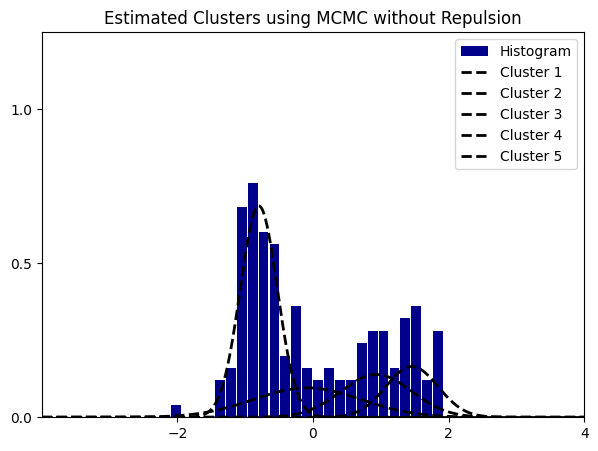

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

# Standardize the galaxy velocity data
scaler = StandardScaler()
acidity_data_scaled = scaler.fit_transform(acidity_data.reshape(-1, 1)).flatten()

# Compute original data mean
data_mean = np.mean(acidity_data)

# Define the number of components (upper bound)
K = 5  

from sklearn.cluster import KMeans

# Use KMeans to Identify Natural Cluster Centers
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(acidity_data_scaled.reshape(-1, 1))
initial_means = np.sort(kmeans.cluster_centers_.flatten())  # Ensure ordering

# Use Data-Driven Weights
counts, _ = np.histogram(acidity_data_scaled, bins=K, density=True)
hist_weights = counts / np.sum(counts)  # Normalize to sum to 1

# Add Concentration to Weights
concentration_param = 5  # Adjust this to control cluster height variability
hist_weights = hist_weights * concentration_param
hist_weights += 0.1  # Small value to avoid zeros
hist_weights /= np.sum(hist_weights)  # Normalize again


def bayesian_gmm_histogram_weights(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.array(hist_weights)))  # Data-driven cluster heights
    means = numpyro.sample("means", dist.Normal(jnp.array(initial_means), 0.2).expand([K]))  # Cluster centers
    std_devs = numpyro.sample("std_devs", dist.HalfNormal(0.8).expand([K]))  # Cluster spread

    # Likelihood: Gaussian Mixture (No Repulsion Term)
    components = dist.Normal(means, std_devs)
    numpyro.sample("obs", dist.MixtureSameFamily(dist.Categorical(weights), components), obs=data)


# Set up MCMC with Slice Sampling
mcmc = MCMC(NUTS(bayesian_gmm_histogram_weights), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), data=jnp.array(acidity_data_scaled))

# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Apply Relabeling Algorithm (Stephens, 2002)
# Compute posterior mean ordering to fix label switching
sorted_indices = np.argsort(np.mean(posterior_samples["means"], axis=0))
posterior_samples["means"] = posterior_samples["means"][:, sorted_indices]
posterior_samples["weights"] = posterior_samples["weights"][:, sorted_indices]
posterior_samples["std_devs"] = posterior_samples["std_devs"][:, sorted_indices]

# Generate density estimates for visualization
x_vals = np.linspace(-4, 4, 1000)
pdf_mixture = np.zeros_like(x_vals)

# Compute mixture density using posterior samples
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_mixture += weight_samples * norm.pdf(x_vals, mean_samples, std_samples)

# Plot histogram with KDE
plt.figure(figsize=(7, 5))
plt.hist(acidity_data_scaled, bins=25, density=True, color='darkblue', rwidth=0.9, label="Histogram")
# Plot each individual Gaussian component separately
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_cluster = weight_samples * norm.pdf(x_vals, mean_samples, std_samples)
    plt.plot(x_vals, pdf_cluster, '--', color='black', linewidth=2, label=f"Cluster {i+1}")  # Dashed lines for each component

plt.xlim(-4, 4)
plt.ylim(0, 1.25)
plt.xticks([-2, 0, 2, 4])
plt.yticks([0, 0.5, 1])
plt.title("Estimated Clusters using MCMC without Repulsion")
plt.legend()

plt.show()


### Repulsive mixture with repulsive prior

/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_9410/2381118011.py:52: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(bayesian_gmm_with_repulsion), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
sample: 100%|██████████| 15000/15000 [00:50<00:00, 299.15it/s, 63 steps of size 8.88e-02. acc. prob=0.95]  


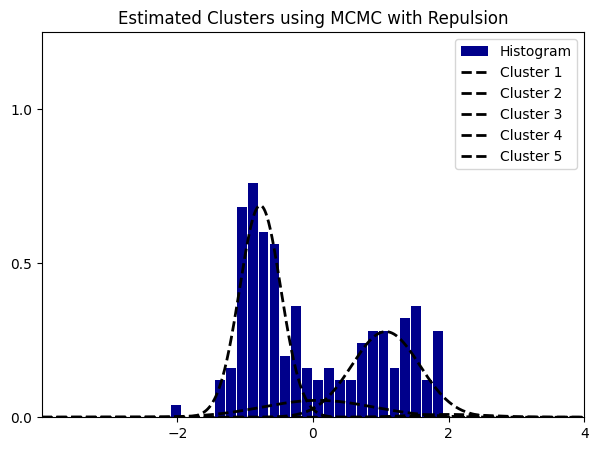

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.cluster import KMeans


# Standardize the galaxy velocity data
scaler = StandardScaler()
acidity_data_scaled = scaler.fit_transform(acidity_data.reshape(-1, 1)).flatten()

# Compute original data mean
data_mean = np.mean(acidity_data)

# Define the number of components (upper bound)
K = 5  

# Use KMeans to Identify Natural Cluster Centers
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(acidity_data_scaled.reshape(-1, 1))
initial_means = np.sort(kmeans.cluster_centers_.flatten())  # Ensure ordering

# Use Data-Driven Weights
counts, _ = np.histogram(acidity_data_scaled, bins=K, density=True)
hist_weights = counts / np.sum(counts)  # Normalize to sum to 1

# Add Concentration to Weights
concentration_param = 5  # Adjust this to control cluster height variability
hist_weights = hist_weights * concentration_param
hist_weights += 0.1  # Small value to avoid zeros
hist_weights /= np.sum(hist_weights)  # Normalize again

def bayesian_gmm_with_repulsion(data):
    weights = numpyro.sample("weights", dist.Dirichlet(jnp.array(hist_weights)))  # Data-driven cluster heights
    means = numpyro.sample("means", dist.Normal(jnp.array(initial_means), 0.2).expand([K]))  # Cluster centers
    std_devs = numpyro.sample("std_devs", dist.HalfNormal(0.8).expand([K]))  # Cluster spread

    # Repulsion Term - Definition 1(i)
    epsilon = 0.5  # Minimum separation threshold
    repulsion_penalty = jnp.sum(jnp.exp(-jnp.square(jnp.diff(jnp.sort(means))) / (2 * epsilon**2)))
    numpyro.factor("repulsion", -repulsion_penalty * 20)  # Apply repulsion penalty

    # Likelihood: Gaussian Mixture
    components = dist.Normal(means, std_devs)
    numpyro.sample("obs", dist.MixtureSameFamily(dist.Categorical(weights), components), obs=data)

# Set up MCMC with Slice Sampling
mcmc = MCMC(NUTS(bayesian_gmm_with_repulsion), num_warmup=5000, num_samples=10000, thinning=10, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), data=jnp.array(acidity_data_scaled))

# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Apply Relabeling Algorithm (Stephens, 2002)
# Compute posterior mean ordering to fix label switching
sorted_indices = np.argsort(np.mean(posterior_samples["means"], axis=0))
posterior_samples["means"] = posterior_samples["means"][:, sorted_indices]
posterior_samples["weights"] = posterior_samples["weights"][:, sorted_indices]
posterior_samples["std_devs"] = posterior_samples["std_devs"][:, sorted_indices]

# Generate density estimates for visualization
x_vals = np.linspace(-4, 4, 1000)
pdf_mixture = np.zeros_like(x_vals)

# Compute mixture density using posterior samples
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_mixture += weight_samples * norm.pdf(x_vals, mean_samples, std_samples)

# Plot histogram with KDE
plt.figure(figsize=(7, 5))
plt.hist(acidity_data_scaled, bins=25, density=True, color='darkblue', rwidth=0.9, label="Histogram")

# Plot each individual Gaussian component separately with black dashed lines
for i in range(K):
    mean_samples = np.mean(posterior_samples["means"][:, i])
    weight_samples = np.mean(posterior_samples["weights"][:, i])
    std_samples = np.mean(posterior_samples["std_devs"][:, i])

    pdf_cluster = weight_samples * norm.pdf(x_vals, mean_samples, std_samples)
    plt.plot(x_vals, pdf_cluster, '--', color='black', linewidth=2, label=f"Cluster {i+1}")  


plt.xlim(-4, 4)
plt.ylim(0, 1.25)
plt.xticks([-2, 0, 2, 4])
plt.yticks([0, 0.5, 1])
plt.title("Estimated Clusters using MCMC with Repulsion")
plt.legend()

plt.show()
